Dataset ja limpo em limpeza.ipynb

imports e utils

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)

from mlp import SklearnMLPModel
from mlp_manual import NumpyMLPModel

NUM_COLS = ["age","education.num","hours.per.week","capital.gain","capital.loss"]
CAT_COLS = ["workclass","education","marital.status","occupation","relationship","race","sex","native.country"]

def make_ohe():
    from sklearn.preprocessing import OneHotEncoder as _OHE
    params = dict(drop="first", handle_unknown="ignore")
    sig = _OHE.__init__.__code__.co_varnames
    if "sparse_output" in sig:
        return _OHE(sparse_output=False, **params)
    else:
        return _OHE(sparse=False, **params)

class Preprocessor:
    def __init__(self, num_cols=NUM_COLS, cat_cols=CAT_COLS):
        self.num_cols = num_cols
        self.cat_cols = cat_cols
        self.ct = ColumnTransformer(
            transformers=[
                ("num", StandardScaler(), self.num_cols),
                ("cat", make_ohe(), self.cat_cols),
            ],
            remainder="drop",
        )
        self.fitted_ = False

    def fit(self, X_train):
        self.ct.fit(X_train); self.fitted_ = True; return self

    def transform(self, X):
        assert self.fitted_, "fit primeiro"
        return self.ct.transform(X)

    def fit_transform(self, X_train):
        self.fit(X_train)
        return self.ct.transform(X_train)


carregar dados + limpeza mínima

In [54]:
df = pd.read_csv("dataset/adult_clean.csv")
df.head()


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,Private,77053,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,Private,186061,Some-college,10,Widowed,Prof-specialty,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [55]:
print(df.isnull().sum())

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64


split 70/15/15 e normalização/one-hot 

In [56]:
y = (df["income"].astype(str) == ">50K").astype(int)
X = df.drop(columns=["income"])

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val
)

prep = Preprocessor(NUM_COLS, CAT_COLS)
X_train_proc = prep.fit_transform(X_train)
X_val_proc   = prep.transform(X_val)
X_test_proc  = prep.transform(X_test)

y_train_np = y_train.to_numpy()
y_val_np   = y_val.to_numpy()
y_test_np  = y_test.to_numpy()

X_train_proc.shape, X_val_proc.shape, X_test_proc.shape


c:\Users\marin\OneDrive\Documentos\insper-Marininha\semestre7\ann-dl\classification_mlp_mng\env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


((22791, 95), (4885, 95), (4885, 95))

treinar SklearnMLPModel e avaliar

In [57]:
from mlp import SklearnMLPModel
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)
import matplotlib.pyplot as plt

# ===== Treino =====
skl = SklearnMLPModel(hidden_layer_sizes=(64,), lr=1e-3, alpha=1e-4,
                      batch_size=128, max_iter=100, early_stopping=True, random_state=42)
skl.fit(X_train_proc, y_train_np)

# ===== Predições =====
y_val_pred  = skl.predict(X_val_proc)
y_test_pred = skl.predict(X_test_proc)
y_test_proba = skl.predict_proba(X_test_proc)

# ===== Métricas de TRAIN =====
y_train_proba_skl = skl.predict_proba(X_train_proc)
y_train_pred_skl  = (y_train_proba_skl >= 0.5).astype(int)


In [58]:
print("TRAIN (sklearn)\n", classification_report(y_train_np, y_train_pred_skl, digits=3))
print("ROC-AUC (train):", roc_auc_score(y_train_np, y_train_proba_skl))
print("AP (PR AUC, train):", average_precision_score(y_train_np, y_train_proba_skl))

# ===== Métricas de VAL/TEST (como você já fazia) =====
print("\nVAL (sklearn)\n", classification_report(y_val_np, y_val_pred, digits=3))
print("TEST (sklearn)\n", classification_report(y_test_np, y_test_pred, digits=3))
print("ROC-AUC (test):", roc_auc_score(y_test_np, y_test_proba))
print("AP (PR AUC, test):", average_precision_score(y_test_np, y_test_proba))

TRAIN (sklearn)
               precision    recall  f1-score   support

           0      0.890     0.931     0.910     17302
           1      0.747     0.639     0.689      5489

    accuracy                          0.861     22791
   macro avg      0.819     0.785     0.800     22791
weighted avg      0.856     0.861     0.857     22791

ROC-AUC (train): 0.9187297736254973
AP (PR AUC, train): 0.7932949020525172

VAL (sklearn)
               precision    recall  f1-score   support

           0      0.884     0.927     0.905      3709
           1      0.727     0.616     0.667      1176

    accuracy                          0.852      4885
   macro avg      0.805     0.771     0.786      4885
weighted avg      0.846     0.852     0.847      4885

TEST (sklearn)
               precision    recall  f1-score   support

           0      0.888     0.930     0.909      3709
           1      0.741     0.632     0.682      1176

    accuracy                          0.858      4885
   m

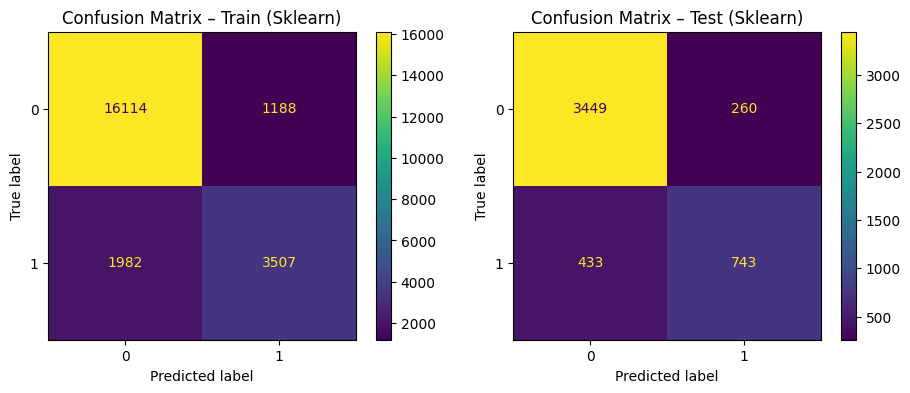

In [59]:
# ===== Confusion matrices: TRAIN e TEST lado a lado =====
fig, axes = plt.subplots(1, 2, figsize=(11,4))
ConfusionMatrixDisplay.from_predictions(y_train_np, y_train_pred_skl, ax=axes[0])
axes[0].set_title("Confusion Matrix – Train (Sklearn)")
ConfusionMatrixDisplay.from_predictions(y_test_np, y_test_pred, ax=axes[1])
axes[1].set_title("Confusion Matrix – Test (Sklearn)")
plt.show()



<Figure size 600x500 with 0 Axes>

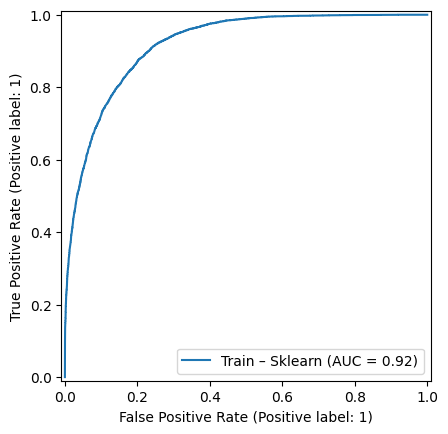

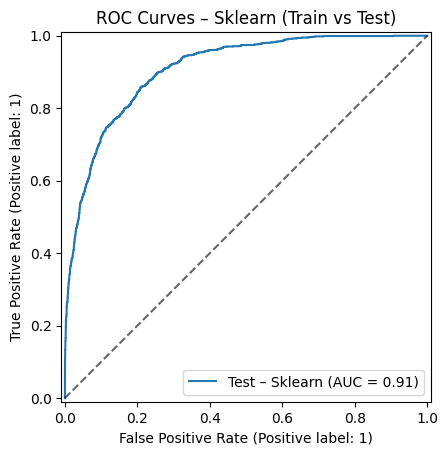

In [60]:
# ===== ROC: TRAIN e TEST na mesma figura =====
plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(y_train_np, y_train_proba_skl, name="Train – Sklearn")
RocCurveDisplay.from_predictions(y_test_np,  y_test_proba,     name="Test – Sklearn")
plt.plot([0,1],[0,1],"k--",alpha=0.6)
plt.title("ROC Curves – Sklearn (Train vs Test)")
plt.show()



<Figure size 600x500 with 0 Axes>

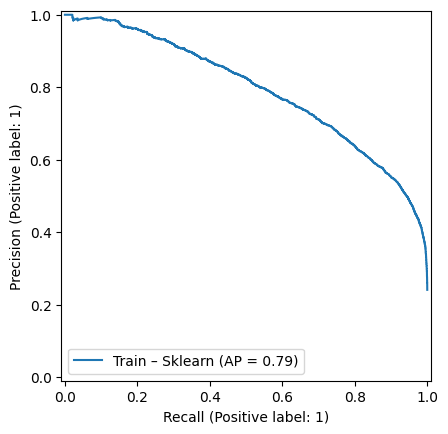

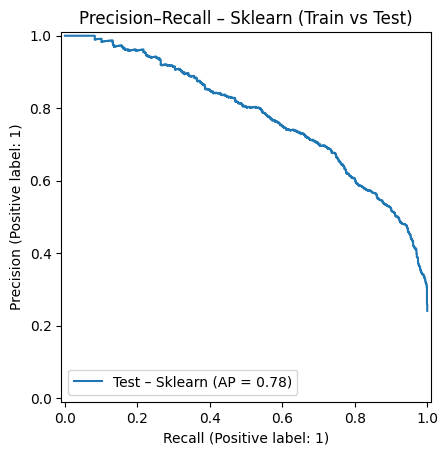

In [61]:
# ===== Precision–Recall: TRAIN e TEST na mesma figura =====
plt.figure(figsize=(6,5))
PrecisionRecallDisplay.from_predictions(y_train_np, y_train_proba_skl, name="Train – Sklearn")
PrecisionRecallDisplay.from_predictions(y_test_np,  y_test_proba,      name="Test – Sklearn")
plt.title("Precision–Recall – Sklearn (Train vs Test)")
plt.show()



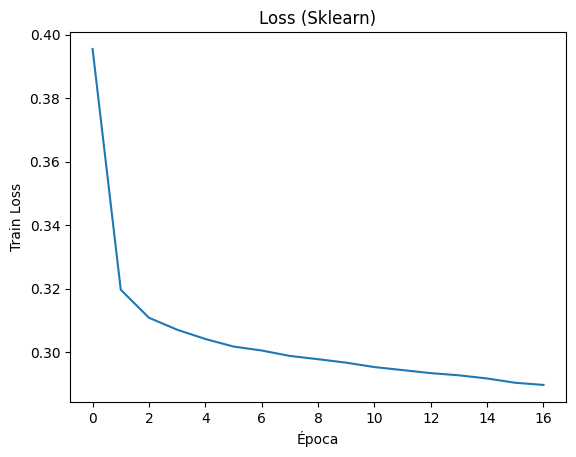

In [62]:
# ===== Curva de loss do sklearn (treino) =====
lc = skl.loss_curve()
if lc is not None:
    plt.figure()
    plt.plot(lc)
    plt.xlabel("Época"); plt.ylabel("Train Loss"); plt.title("Loss (Sklearn)")
    plt.show()

treinar NumpyMLPModel e avaliar

In [63]:
from mlp_manual import NumpyMLPModel
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)
import matplotlib.pyplot as plt

# ===== Treino =====
npmlp = NumpyMLPModel(n_hidden=64, lr=1e-3, l2=1e-4, batch_size=128, epochs=80, patience=8, seed=42)
npmlp.fit(X_train_proc, y_train_np, X_val_proc, y_val_np)

# ===== Predições TEST =====
y_test_proba_np = npmlp.predict_proba(X_test_proc)
y_test_pred_np  = npmlp.predict(X_test_proc)

# ===== Predições TRAIN =====
y_train_proba_np = npmlp.predict_proba(X_train_proc)
y_train_pred_np  = (y_train_proba_np >= 0.5).astype(int)



In [64]:
# ===== Métricas TRAIN/TEST =====
print("TRAIN (NumPy)\n", classification_report(y_train_np, y_train_pred_np, digits=3))
print("ROC-AUC (train):", roc_auc_score(y_train_np, y_train_proba_np))
print("AP (PR AUC, train):", average_precision_score(y_train_np, y_train_proba_np))

print("\nTEST (NumPy)\n", classification_report(y_test_np, y_test_pred_np, digits=3))
print("ROC-AUC (test):", roc_auc_score(y_test_np, y_test_proba_np))
print("AP (PR AUC, test):", average_precision_score(y_test_np, y_test_proba_np))



TRAIN (NumPy)
               precision    recall  f1-score   support

           0      0.865     0.927     0.895     17302
           1      0.704     0.544     0.614      5489

    accuracy                          0.835     22791
   macro avg      0.784     0.736     0.754     22791
weighted avg      0.826     0.835     0.827     22791

ROC-AUC (train): 0.886153055577849
AP (PR AUC, train): 0.7183275505433925

TEST (NumPy)
               precision    recall  f1-score   support

           0      0.870     0.932     0.900      3709
           1      0.723     0.561     0.632      1176

    accuracy                          0.843      4885
   macro avg      0.796     0.747     0.766      4885
weighted avg      0.835     0.843     0.835      4885

ROC-AUC (test): 0.8891615219827482
AP (PR AUC, test): 0.7318330700854239


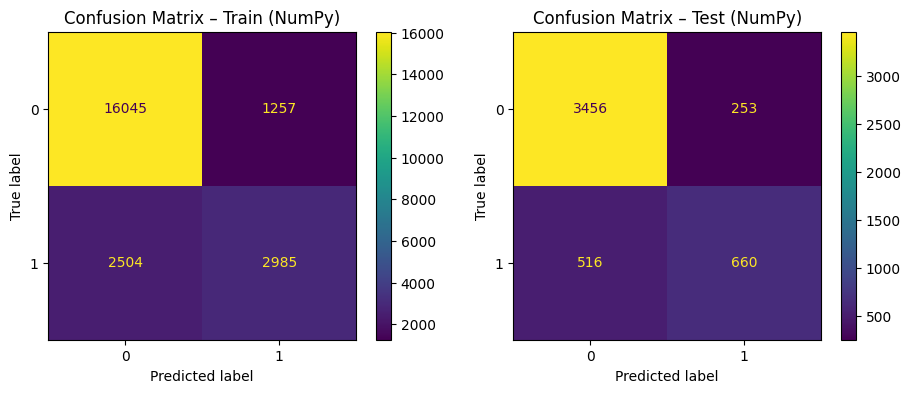

In [65]:
# ===== Confusion matrices: TRAIN e TEST lado a lado =====
fig, axes = plt.subplots(1, 2, figsize=(11,4))
ConfusionMatrixDisplay.from_predictions(y_train_np, y_train_pred_np, ax=axes[0])
axes[0].set_title("Confusion Matrix – Train (NumPy)")
ConfusionMatrixDisplay.from_predictions(y_test_np, y_test_pred_np, ax=axes[1])
axes[1].set_title("Confusion Matrix – Test (NumPy)")
plt.show()



<Figure size 600x500 with 0 Axes>

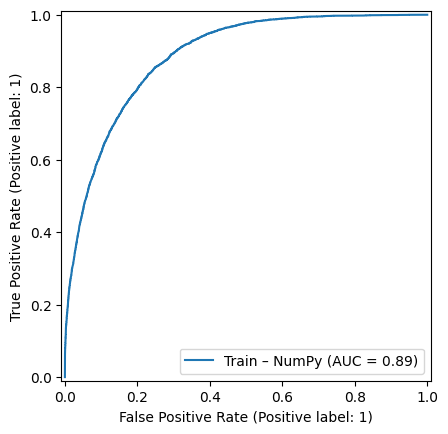

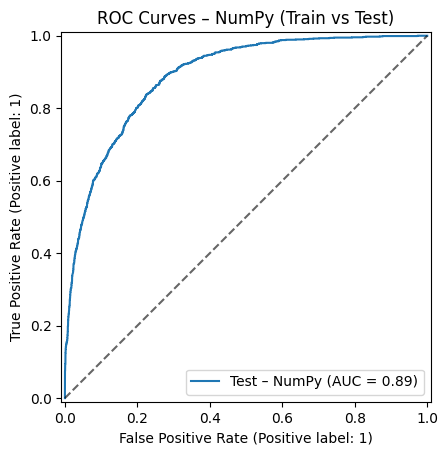

In [66]:
# ===== ROC: TRAIN e TEST na mesma figura =====
plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(y_train_np, y_train_proba_np, name="Train – NumPy")
RocCurveDisplay.from_predictions(y_test_np,  y_test_proba_np,  name="Test – NumPy")
plt.plot([0,1],[0,1],"k--",alpha=0.6)
plt.title("ROC Curves – NumPy (Train vs Test)")
plt.show()



<Figure size 600x500 with 0 Axes>

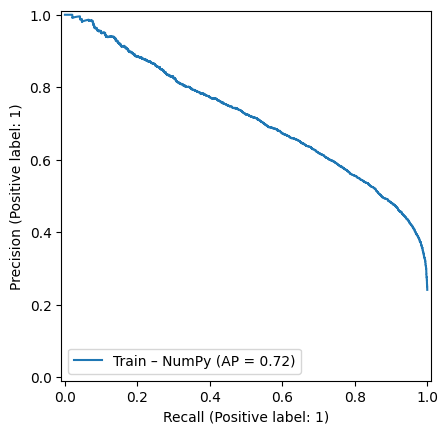

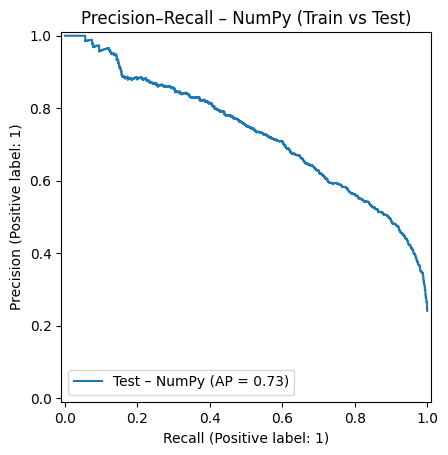

In [67]:
# ===== Precision–Recall: TRAIN e TEST na mesma figura =====
plt.figure(figsize=(6,5))
PrecisionRecallDisplay.from_predictions(y_train_np, y_train_proba_np, name="Train – NumPy")
PrecisionRecallDisplay.from_predictions(y_test_np,  y_test_proba_np,  name="Test – NumPy")
plt.title("Precision–Recall – NumPy (Train vs Test)")
plt.show()



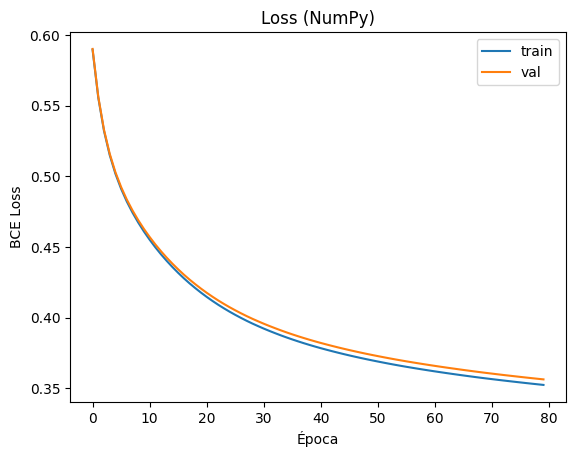

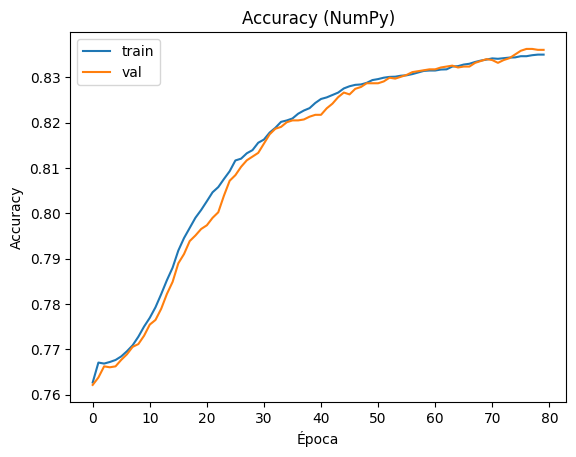

In [68]:
# ===== Curvas (NumPy) – você já tinha =====
if npmlp.hist is not None:
    plt.figure(); plt.plot(npmlp.hist["loss_tr"], label="train"); plt.plot(npmlp.hist["loss_val"], label="val")
    plt.xlabel("Época"); plt.ylabel("BCE Loss"); plt.title("Loss (NumPy)"); plt.legend(); plt.show()

    plt.figure(); plt.plot(npmlp.hist["acc_tr"], label="train"); plt.plot(npmlp.hist["acc_val"], label="val")
    plt.xlabel("Época"); plt.ylabel("Accuracy"); plt.title("Accuracy (NumPy)"); plt.legend(); plt.show()


Baseline sempre <=50k

In [69]:
import numpy as np
from sklearn.metrics import classification_report

y_pred_base = np.zeros_like(y_test_np)  # classe 0
print("BASELINE (sempre <=50K)\n", classification_report(y_test_np, y_pred_base, digits=3))


BASELINE (sempre <=50K)
               precision    recall  f1-score   support

           0      0.759     1.000     0.863      3709
           1      0.000     0.000     0.000      1176

    accuracy                          0.759      4885
   macro avg      0.380     0.500     0.432      4885
weighted avg      0.576     0.759     0.655      4885



c:\Users\marin\OneDrive\Documentos\insper-Marininha\semestre7\ann-dl\classification_mlp_mng\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\marin\OneDrive\Documentos\insper-Marininha\semestre7\ann-dl\classification_mlp_mng\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\marin\OneDrive\Documentos\insper-Marininha\semestre7\ann-dl\classification_mlp_mng\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and be

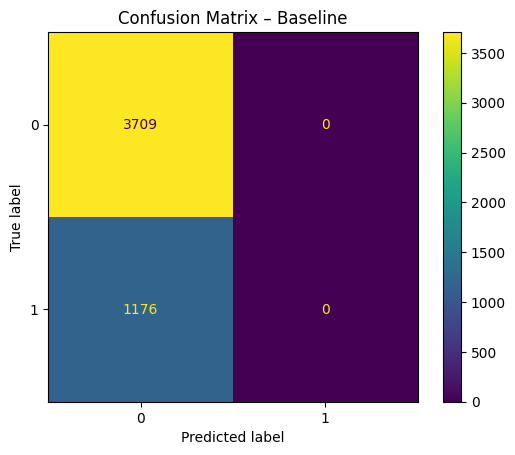

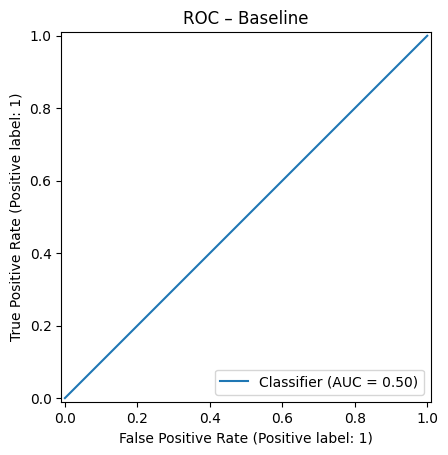

In [70]:
# curvas (baseline)
ConfusionMatrixDisplay.from_predictions(y_test_np, y_pred_base) 
plt.title("Confusion Matrix – Baseline"); plt.show()
RocCurveDisplay.from_predictions(y_test_np, y_pred_base)
plt.title("ROC – Baseline"); plt.show()


In [71]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

def avaliar_modelo(nome, y_true, y_pred, y_proba):
    return {
        "Modelo": nome,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_proba),
    }

comparacao = []
comparacao.append(avaliar_modelo("MLP Manual (NumPy)", y_test_np, y_test_pred_np, y_test_proba_np))
comparacao.append(avaliar_modelo("MLP Scikit-Learn", y_test, y_test_pred, y_test_proba))

df_comp = pd.DataFrame(comparacao)
display(df_comp.round(3))


,Modelo,Accuracy,Precision,Recall,F1,ROC-AUC
0,MLP Manual (NumPy),0.843,0.723,0.561,0.632,0.889
1,MLP Scikit-Learn,0.858,0.741,0.632,0.682,0.908
